In [22]:
from pathlib import Path
import xml.etree.ElementTree as et
import unicodedata
import re
from tqdm import tqdm
import pyopenjtalk
import MeCab
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [23]:
class CustomMeCabTagger(MeCab.Tagger):

    COLUMNS = ['hyousou', 'hinnshi', 'hinnshi_sai1', 'hinnshi_sai2', 'hinnshi_sai3', 'katuyou_kata', 'katuyou_kei', 'gennkeki', 'yomi', 'hatuonn']

    def parseToDataFrame(self, text: str) -> pd.DataFrame:
        """テキストを parse した結果を Pandas DataFrame として返す"""
        results = []
        for line in self.parse(text).split('\n'):
            if line == 'EOS':
                break
            surface, feature = line.split('\t')
            feature = [None if f == '*' else f for f in feature.split(',')]
            results.append([surface, *feature])
        return pd.DataFrame(results, columns=type(self).COLUMNS)

In [24]:
def is_japanese(text):
    japanese_pattern = re.compile("[\u3000-\u303F\u3040-\u309F\u30A0-\u30FF\uFF65-\uFF9F\u4E00-\u9FAF\u3400-\u4DBF]")
    return bool(japanese_pattern.search(text))

In [25]:
data_dir = Path('/home/minami/wiki_ja/text_fixed')
data_path_list = list(data_dir.glob('**/wiki_*'))
mecab = CustomMeCabTagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
text_len_list = []
for data_path in tqdm(data_path_list):
    tree = et.parse(str(data_path))
    root = tree.getroot()
    doc_list = root.findall('doc')
    for doc in doc_list:
        text = unicodedata.normalize('NFKC', doc.text)
        text = text.replace('\n', '')
        text = re.sub(r'[“”]', '', text)
        text = re.sub(r'https?:\/\/.*?[\r\n ]', '', text)
        if len(text) < 30 or not is_japanese(text):
            continue
        text_len_list.append(len(text))

100%|██████████| 3784/3784 [02:13<00:00, 28.33it/s]


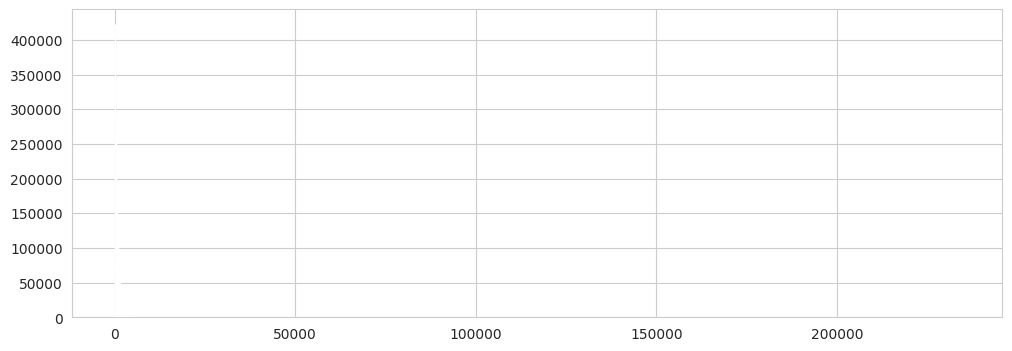

In [26]:
plt.figure(figsize=(12, 4))
plt.hist(text_len_list, bins=1000)
plt.show()

In [27]:
pd.DataFrame(
    {
        'text_len': text_len_list,
    }
).describe()

,text_len
count,1.337085e+06
mean,9.926473e+02
std,2.076637e+03
min,3.000000e+01
25%,2.090000e+02
50%,4.600000e+02
75%,1.003000e+03
max,2.340480e+05
